# Open Sentinel-2 Data with GDAL and EOPFZARR


This Jupyter notebook demonstrates how to open and explore Sentinel-2 data (both L1C and L2A products) using GDAL with the eopfzarr plugin, mirroring the structure and functionality of the [xarray-eopf example notebook](https://github.com/EOPF-Sample-Service/xarray-eopf/blob/main/examples/open-sen2.ipynb). While the xarray-eopf notebook uses `xr.open_datatree` for hierarchical access and built-in plotting (e.g., `.plot.imshow`), here we use GDAL to open the Zarr root or subdatasets, read data into NumPy arrays, and visualize with Matplotlib. This provides similar capabilities: inspecting metadata, accessing bands (e.g., reflectance at different resolutions like r10m), and plotting single bands or RGB composites.

eopfzarr enhances GDAL with automatic geospatial metadata (CRS, geotransform) for EOPF Zarr formats, making it efficient for remote access without full downloads.

**Note:** This is analogous to the xarray-eopf workflow but GDAL-centric. For analysis-ready formats (e.g., unified grids), you could combine with xarray by wrapping GDAL-read arrays (as shown briefly). Install eopfzarr from [the repo](https://github.com/EOPF-Sample-Service/GDAL-ZARR-EOPF) and ensure GDAL recognizes the driver.

## Setup

In [63]:
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np

# Enable GDAL exceptions
gdal.UseExceptions()

# Helper function for eopfzarr paths (remote access)
def eopfzarr_path(url, subdataset=None):
    base = f'EOPFZARR:"/vsicurl/{url}"'
    return f'{base}:{subdataset}' if subdataset else base

# Helper function for eopfzarr paths (remote access)
def eopfzarr_path_s3(url, subdataset=None):
    base = f'EOPFZARR:"/vsis3/{url}"'
    return f'{base}:{subdataset}' if subdataset else base

# Sample URLs from xarray-eopf notebook (L1C and L2A)
l1c_url = 'https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:202504-s02msil1c/30/products/cpm_v256/S2B_MSIL1C_20250430T101559_N0511_R065_T32TLQ_20250430T124542.zarr'
l2a_url = 'https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202509-s02msil2a/11/products/cpm_v256/S2A_MSIL2A_20250911T082751_N0511_R021_T39WWM_20250911T102515.zarr'

## Open as Dataset (L1C Product)

Similar to the xarray-eopf section "Open as Dataset", we open the root Zarr and list subdatasets, then flatten to band-specific access. For L1C (TOA reflectance), values are scaled (0-10000).


### Open the Product

In [64]:
# Open L1C root
l1c_root_ds = gdal.Open(eopfzarr_path(l1c_url))

# Inspect basic info (analogous to printing datatree)
print(f"Driver: {l1c_root_ds.GetDriver().ShortName}")
print(f"Projection (CRS): {l1c_root_ds.GetProjection()}")
print(f"GeoTransform: {l1c_root_ds.GetGeoTransform()}")

# List subdatasets (hierarchical, like datatree groups)
subdatasets = l1c_root_ds.GetMetadata("SUBDATASETS")
print("Available Subdatasets for L1C:")
for key, value in subdatasets.items():
    if key.startswith("SUBDATASET_") and '_DESC' not in key:
        print(f"  {value.split(':')[-1]}")  # e.g., measurements/reflectance/r10m/b02

l1c_root_ds = None  # Close

Driver: EOPFZARR
Projection (CRS): PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32632"]]
GeoTransform: (300000.0, 214.453125, 0.0, 5000040.0, 0.0, -214.453125)
Available Subdatasets for L1C:
  202504-s02msil1c/30/products/cpm_v256/S2B_MSIL1C_20250430T101559_N0511_R065_T32TLQ_20250430T124542.zarr/conditions/geometry/angle"
  202504-s02msil1c/30/products/cpm_v256/S2B_MSIL1C_20250430T101559_N0511_R065_T32TLQ_20250430T124542.zarr/conditions/geometry/band"
 

Warning 1: Unable to save auxiliary information in ZARR:"/vsicurl/https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:202504-s02msil1c/30/products/cpm_v256/S2B_MSIL1C_20250430T101559_N0511_R065_T32TLQ_20250430T124542.zarr".aux.xml.


### Explore the Data Structure

GDAL lists subdatasets corresponding to groups like `measurements/reflectance/r10m/b04` (similar to `dt['measurements']['reflectance']['r10m']['b04']`).


### Access and Plot a Specific Band (e.g., B01 at r60m)

Band Description: 
Size: 1830 x 1830
NoData: 0.0


Warning 1: Unable to save auxiliary information in ZARR:"/vsicurl/https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:202504-s02msil1c/30/products/cpm_v256/S2B_MSIL1C_20250430T101559_N0511_R065_T32TLQ_20250430T124542.zarr":/measurements/reflectance/r60m/b01.aux.xml.


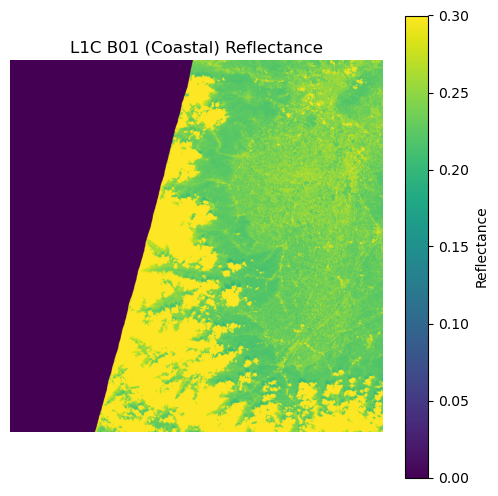

In [65]:
# Open specific band (analogous to ds.b01 or dt['...']['b01'])
l1c_b01_path = eopfzarr_path(l1c_url, 'measurements/reflectance/r60m/b01')
l1c_b01_ds = gdal.Open(l1c_b01_path)
l1c_b01_band = l1c_b01_ds.GetRasterBand(1)
# Inspect band (like printing ds.b04)
print(f"Band Description: {l1c_b01_band.GetDescription()}")
print(f"Size: {l1c_b01_ds.RasterXSize} x {l1c_b01_ds.RasterYSize}")
print(f"NoData: {l1c_b01_band.GetNoDataValue()}")

# Read subset as array (for efficiency; full size may be large, e.g., 10980x10980)
subset_size = 1830  # Example from xarray notebook (y:1830, x:1830 in some dims)
l1c_b01_data = l1c_b01_band.ReadAsArray(0, 0, subset_size, subset_size).astype(np.float32) / 10000  # Scale to 0-1

l1c_b01_ds = None

# Plot (similar to dt['...']['b04'].plot.imshow(vmin=0., vmax=0.3))
plt.figure(figsize=(6, 6))
plt.imshow(l1c_b01_data, vmin=0., vmax=0.3, cmap='viridis')
plt.title('L1C B01 (Coastal) Reflectance')
plt.colorbar(label='Reflectance')
plt.axis('off')
plt.show()

### Plot RGB Composite (Flattened Access)

Analogous to accessing multiple bands in a flattened dataset.


Warning 1: Unable to save auxiliary information in ZARR:"/vsicurl/https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:202504-s02msil1c/30/products/cpm_v256/S2B_MSIL1C_20250430T101559_N0511_R065_T32TLQ_20250430T124542.zarr":/measurements/reflectance/r10m/b04.aux.xml.
Warning 1: Unable to save auxiliary information in ZARR:"/vsicurl/https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:202504-s02msil1c/30/products/cpm_v256/S2B_MSIL1C_20250430T101559_N0511_R065_T32TLQ_20250430T124542.zarr":/measurements/reflectance/r10m/b03.aux.xml.
Warning 1: Unable to save auxiliary information in ZARR:"/vsicurl/https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:202504-s02msil1c/30/products/cpm_v256/S2B_MSIL1C_20250430T101559_N0511_R065_T32TLQ_20250430T124542.zarr":/measurements/reflectance/r10m/b02.aux.xml.


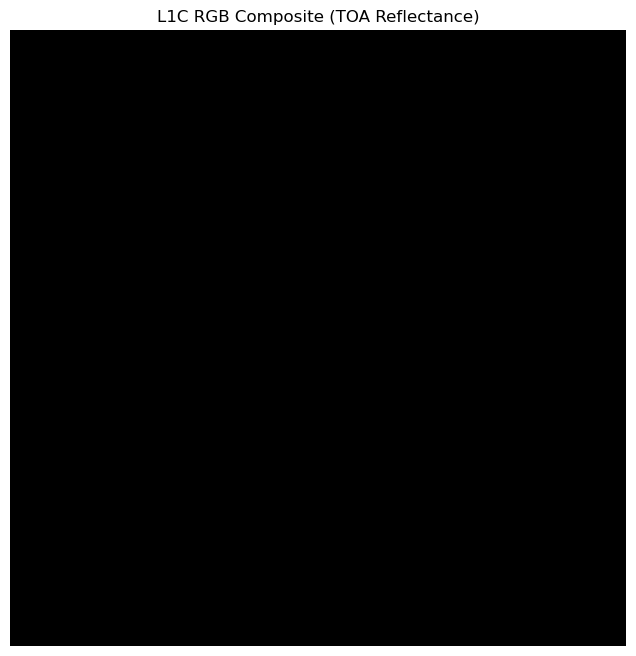

In [66]:
def load_band_gdal(url, subdataset, size=1830):
    path = eopfzarr_path(url, subdataset)
    ds = gdal.Open(path)
    band = ds.GetRasterBand(1)
    data = band.ReadAsArray(0, 0, size, size).astype(np.float32) / 10000
    ds = None
    return np.clip(data, 0, 1)

# Load RGB bands (B04 red, B03 green, B02 blue at r10m)
l1c_red = load_band_gdal(l1c_url, 'measurements/reflectance/r10m/b04')
l1c_green = load_band_gdal(l1c_url, 'measurements/reflectance/r10m/b03')
l1c_blue = load_band_gdal(l1c_url, 'measurements/reflectance/r10m/b02')

# Stack and plot (similar to plotting composite in xarray)
l1c_rgb = np.dstack((l1c_red, l1c_green, l1c_blue))
plt.figure(figsize=(8, 8))
plt.imshow(l1c_rgb)
plt.title('L1C RGB Composite (TOA Reflectance)')
plt.axis('off')
plt.show()

# Open as Dataset (L2A Product)

Repeat for L2A (BOA reflectance), which may appear less hazy due to atmospheric correction. Structure mirrors L1C for comparison.


## Open the Product

In [67]:
# Open L2A root
l2a_root_ds = gdal.Open(eopfzarr_path(l2a_url))

# Inspect
print(f"Driver: {l2a_root_ds.GetDriver().ShortName}")
print(f"Projection (CRS): {l2a_root_ds.GetProjection()}")
print(f"GeoTransform: {l2a_root_ds.GetGeoTransform()}")

# List subdatasets
subdatasets = l2a_root_ds.GetMetadata("SUBDATASETS")
print("Available Subdatasets for L2A:")
for key, value in subdatasets.items():
    if key.startswith("SUBDATASET_") and '_DESC' not in key:
        print(f"  {value.split(':')[-1]}")

l2a_root_ds = None

Driver: EOPFZARR
Projection (CRS): PROJCS["WGS 84 / UTM zone 39N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",51],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32639"]]
GeoTransform: (499980.0, 214.453125, 0.0, 7200000.0, 0.0, -214.453125)
Available Subdatasets for L2A:
  202509-s02msil2a/11/products/cpm_v256/S2A_MSIL2A_20250911T082751_N0511_R021_T39WWM_20250911T102515.zarr/conditions/geometry/angle"
  202509-s02msil2a/11/products/cpm_v256/S2A_MSIL2A_20250911T082751_N0511_R021_T39WWM_20250911T102515.zarr/conditions/geometry/band"


Warning 1: Unable to save auxiliary information in ZARR:"/vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202509-s02msil2a/11/products/cpm_v256/S2A_MSIL2A_20250911T082751_N0511_R021_T39WWM_20250911T102515.zarr".aux.xml.


## Access and Plot a Specific Band (e.g., B01 at r60m)

From xarray notebook examples (e.g., ds.b01.plot).



Warning 1: Unable to save auxiliary information in ZARR:"/vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202509-s02msil2a/11/products/cpm_v256/S2A_MSIL2A_20250911T082751_N0511_R021_T39WWM_20250911T102515.zarr":/measurements/reflectance/r60m/b01.aux.xml.


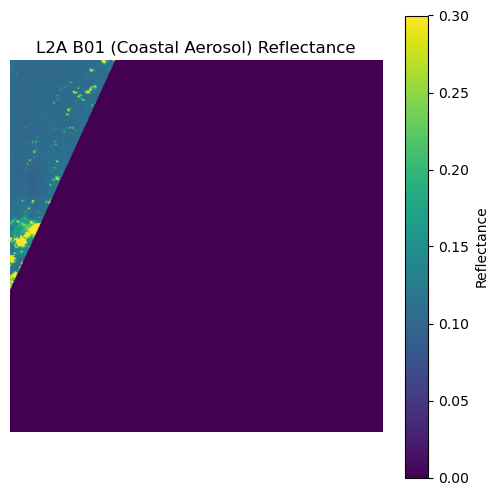

In [68]:
# Open B01 (coastal aerosol, often at r60m)
l2a_b01_path = eopfzarr_path(l2a_url, 'measurements/reflectance/r60m/b01')  # Adjust if resolution differs
l2a_b01_ds = gdal.Open(l2a_b01_path)
l2a_b01_band = l2a_b01_ds.GetRasterBand(1)

# Read subset (L2A tiles may vary; use smaller for r60m, e.g., 1830x1830)
l2a_b01_data = l2a_b01_band.ReadAsArray(0, 0, 1830, 1830).astype(np.float32) / 10000

l2a_b01_ds = None

# Plot (similar to ds.b01.plot(vmin=0., vmax=0.3))
plt.figure(figsize=(6, 6))
plt.imshow(l2a_b01_data, vmin=0., vmax=0.3, cmap='viridis')
plt.title('L2A B01 (Coastal Aerosol) Reflectance')
plt.colorbar(label='Reflectance')
plt.axis('off')
plt.show()

## Plot RGB Composite

Warning 1: Unable to save auxiliary information in ZARR:"/vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202509-s02msil2a/11/products/cpm_v256/S2A_MSIL2A_20250911T082751_N0511_R021_T39WWM_20250911T102515.zarr":/measurements/reflectance/r10m/b04.aux.xml.
Warning 1: Unable to save auxiliary information in ZARR:"/vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202509-s02msil2a/11/products/cpm_v256/S2A_MSIL2A_20250911T082751_N0511_R021_T39WWM_20250911T102515.zarr":/measurements/reflectance/r10m/b03.aux.xml.
Warning 1: Unable to save auxiliary information in ZARR:"/vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202509-s02msil2a/11/products/cpm_v256/S2A_MSIL2A_20250911T082751_N0511_R021_T39WWM_20250911T102515.zarr":/measurements/reflectance/r10m/b02.aux.xml.


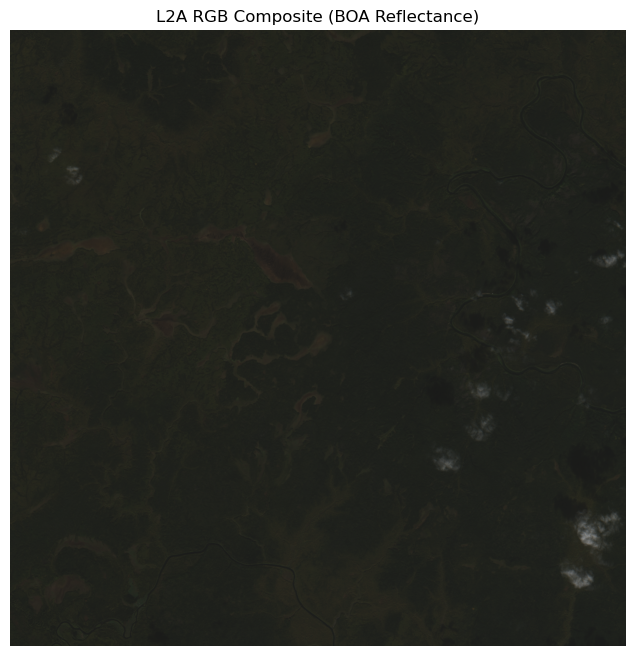

In [69]:
# Load RGB for L2A (B04, B03, B02 at r10m)
l2a_red = load_band_gdal(l2a_url, 'measurements/reflectance/r10m/b04')
l2a_green = load_band_gdal(l2a_url, 'measurements/reflectance/r10m/b03')
l2a_blue = load_band_gdal(l2a_url, 'measurements/reflectance/r10m/b02')

# Stack and plot
l2a_rgb = np.dstack((l2a_red, l2a_green, l2a_blue))
plt.figure(figsize=(8, 8))
plt.imshow(l2a_rgb, cmap='viridis')
plt.title('L2A RGB Composite (BOA Reflectance)')
plt.axis('off')
plt.show()

## Open as Dataset in Analysis Mode


To mimic "analysis mode" (unified grid, etc.), read bands and wrap in xarray for advanced ops, bridging GDAL/eopfzarr with xarray-eopf style.


Warning 1: Unable to save auxiliary information in ZARR:"/vsicurl/https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202509-s02msil2a/11/products/cpm_v256/S2A_MSIL2A_20250911T082751_N0511_R021_T39WWM_20250911T102515.zarr":/measurements/reflectance/r10m/b02.aux.xml.


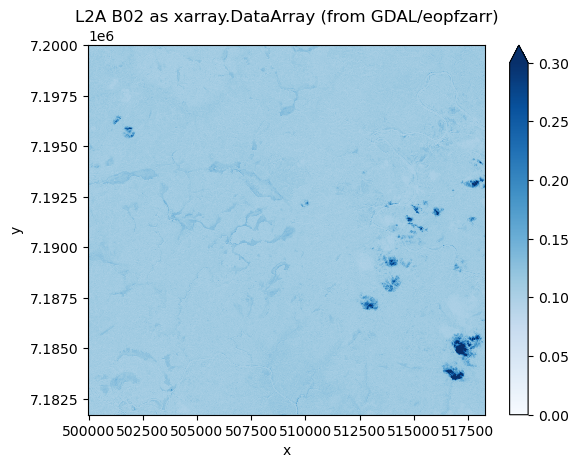

In [70]:
import xarray as xr

# Example: Load L2A B02 via GDAL, wrap in DataArray
l2a_b02_path = eopfzarr_path(l2a_url, 'measurements/reflectance/r10m/b02')
l2a_b02_ds = gdal.Open(l2a_b02_path)
transform = l2a_b02_ds.GetGeoTransform()
crs = l2a_b02_ds.GetProjection()
data = l2a_b02_ds.GetRasterBand(1).ReadAsArray(0, 0, 1830, 1830).astype(np.float32) / 10000
l2a_b02_ds = None

# Create DataArray (unified coords)
height, width = data.shape
x = np.arange(width) * transform[1] + transform[0]
y = np.arange(height) * transform[5] + transform[3]
da = xr.DataArray(data, dims=['y', 'x'], coords={'y': y, 'x': x}, attrs={'crs': crs})

# Plot xarray-style
da.plot.imshow(vmin=0., vmax=0.3, cmap='Blues')
plt.title('L2A B02 as xarray.DataArray (from GDAL/eopfzarr)')
plt.show()

This provides analysis-ready data with geospatial coords, similar to xarray-eopf's flattened dataset.


# Conclusion


Yes, we can replicate the xarray-eopf notebook's plotting (single bands, composites) using GDAL/eopfzarr by reading arrays and using Matplotlib. We've divided it by product (L1C TOA vs. L2A BOA) for comparison—L2A often looks clearer. Extend with full-tile reads, NDVI computation, or GDAL CLI tools (e.g., gdalwarp for reprojection). For pure xarray workflows, use the original; this GDAL approach suits raster-focused tasks.

